In [49]:
import os
import pandas as pd
import matplotlib.pyplot as plt

import pvlib
from pvlib.pvsystem import *
from pvlib.location import *
from pvlib.modelchain import *

### Declare file paths

In [50]:
PATH_OUT = '../data/input/pv_capacity_factors'

### Define Location

In [51]:
# locational data from the HKW Süd in Leipzig
location = Location(
    latitude=51.2977709091898,
    longitude=12.384516163433474,
    name='Leipzig',
    altitude=113,
    tz='Etc/GMT-1')

### Define Weather

In [52]:
weather = pvlib.iotools.get_pvgis_tmy(
    latitude=location.latitude, 
    longitude=location.longitude)[0]

weather.index.name = "utc_time"

# Replace Test Reference Year timestamps with continuouse timestamps
weather.index = pd.date_range(
    start ="2017-01-01 00:00",
    freq='h',
    periods=8760,
    tz = 'UTC')


### Specify module parameters

In [53]:
sandia_modules = pvlib.pvsystem.retrieve_sam('SandiaMod')
sapm_inverters = pvlib.pvsystem.retrieve_sam('cecinverter')
module = sandia_modules['Canadian_Solar_CS5P_220M___2009_']
inverter = sapm_inverters['ABB__MICRO_0_25_I_OUTD_US_208__208V_']
temperature_model_parameters = pvlib.temperature.TEMPERATURE_MODEL_PARAMETERS['sapm']['open_rack_glass_glass']

### Define PV-System

In [54]:
mount = FixedMount(
    surface_tilt=45,
    surface_azimuth=270
)
array = Array(
    mount=mount,
    module_parameters=module,
    temperature_model_parameters=temperature_model_parameters
)
system = PVSystem(
    arrays=[array],
    inverter_parameters=inverter
)
mc = ModelChain(system, location)
mc.run_model(weather)

ModelChain: 
  name: None
  clearsky_model: ineichen
  transposition_model: haydavies
  solar_position_method: nrel_numpy
  airmass_model: kastenyoung1989
  dc_model: sapm
  ac_model: sandia_inverter
  aoi_model: sapm_aoi_loss
  spectral_model: no_spectral_loss
  temperature_model: sapm_temp
  losses_model: no_extra_losses

In [55]:
print(mc.results.dc)

                           i_sc  i_mp  v_oc  v_mp  p_mp  i_x  i_xx
2017-01-01 00:00:00+00:00   0.0   0.0   0.0   0.0   0.0  0.0   0.0
2017-01-01 01:00:00+00:00   0.0   0.0   0.0   0.0   0.0  0.0   0.0
2017-01-01 02:00:00+00:00   0.0   0.0   0.0   0.0   0.0  0.0   0.0
2017-01-01 03:00:00+00:00   0.0   0.0   0.0   0.0   0.0  0.0   0.0
2017-01-01 04:00:00+00:00   0.0   0.0   0.0   0.0   0.0  0.0   0.0
...                         ...   ...   ...   ...   ...  ...   ...
2017-12-31 19:00:00+00:00   0.0   0.0   0.0   0.0   0.0  0.0   0.0
2017-12-31 20:00:00+00:00   0.0   0.0   0.0   0.0   0.0  0.0   0.0
2017-12-31 21:00:00+00:00   0.0   0.0   0.0   0.0   0.0  0.0   0.0
2017-12-31 22:00:00+00:00   0.0   0.0   0.0   0.0   0.0  0.0   0.0
2017-12-31 23:00:00+00:00   0.0   0.0   0.0   0.0   0.0  0.0   0.0

[8760 rows x 7 columns]


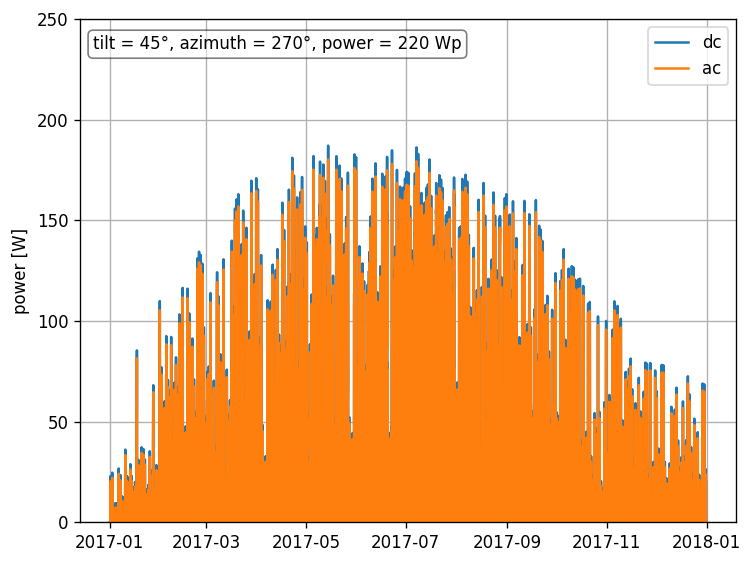

In [56]:
module_power = module.Impo * module.Vmpo

fig, ax = plt.subplots(dpi=120)
plt.plot(mc.results.dc['p_mp'], label='dc')
plt.plot(mc.results.ac, label='ac')
plt.ylabel('power [W]')
plt.ylim(0, 250)
ax.text(
    0.02,
    0.94,
    f'tilt = {mount.surface_tilt}°, azimuth = {mount.surface_azimuth}°, power = {round(module_power)} Wp',
    transform=ax.transAxes,
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
plt.grid()
plt.legend()
fig.tight_layout()

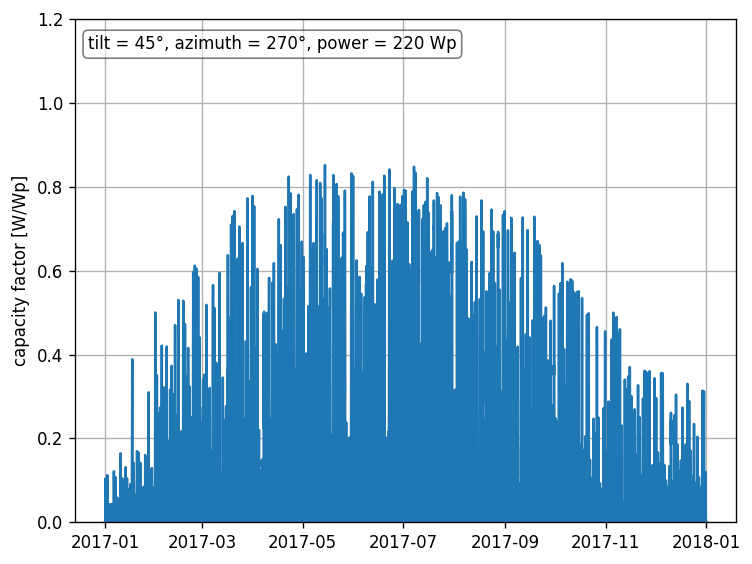

In [57]:
module_power = module.Impo * module.Vmpo

fig, ax = plt.subplots(dpi=120)
plt.plot(mc.results.dc['p_mp'] / module_power)
plt.ylabel('capacity factor [W/Wp]')
plt.ylim(0, 1.2)
ax.text(
    0.02,
    0.94,
    f'tilt = {mount.surface_tilt}°, azimuth = {mount.surface_azimuth}°, power = {round(module_power)} Wp',
    transform=ax.transAxes,
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
plt.grid()
fig.tight_layout()


In [58]:
# capacity_factors = pd.DataFrame(
#     {'timestamps': mc.results.dc.index,
#      'dc_power': mc.results.dc['p_mp'].round(3),
#      'capacity_factor': (mc.results.dc['p_mp'] / module_power).round(3)})
# capacity_factors.index = range(1, len(capacity_factors) + 1)

# leap_year_rows = capacity_factors.tail(24)

# capacity_factors = pd.concat([capacity_factors, leap_year_rows], ignore_index=True)
# capacity_factors['timestamps'] = pd.date_range(
#     start='2024-01-01 00:00:00',
#     end='2024-12-31 23:00:00',
#     freq='H'
# )
# capacity_factors.index += 1

# print(capacity_factors)


In [59]:
# if not os.path.exists(PATH_OUT):
#     os.makedirs(PATH_OUT)

# capacity_factors.to_csv(
#     f'{PATH_OUT}/' +
#      f'{location.name.lower()}_' + 
#      f't{mount.surface_tilt}_' +
#      f'a{mount.surface_azimuth}.csv')

In [60]:
# Nach der Erstellung der Rohdaten für capacity_factors
# Ändere diesen Code-Abschnitt:

# 1. Erstelle Schaltjahr-Daten (2024)
leap_capacity_factors = pd.DataFrame(
    {'timestamps': mc.results.dc.index,
     'dc_power': mc.results.dc['p_mp'].round(3),
     'capacity_factor': (mc.results.dc['p_mp'] / module_power).round(3)})
leap_capacity_factors.index = range(1, len(leap_capacity_factors) + 1)

# Dupliziere die letzten 24 Stunden (29. Februar)
leap_year_extra_day = leap_capacity_factors.iloc[59*24:60*24].copy()
leap_capacity_factors = pd.concat([leap_capacity_factors, leap_year_extra_day], ignore_index=True)
leap_capacity_factors.index += 1
leap_capacity_factors.index.name = "t"  # Rename the index to "t"

# Setze korrekte Timestamps für Schaltjahr 2024
leap_capacity_factors['timestamps'] = pd.date_range(
    start='2024-01-01 00:00:00',
    end='2024-12-31 23:00:00',
    freq='H'
)

# 2. Erstelle Normaljahr-Daten (2025)
normal_capacity_factors = pd.DataFrame(
    {'timestamps': mc.results.dc.index,
     'dc_power': mc.results.dc['p_mp'].round(3),
     'capacity_factor': (mc.results.dc['p_mp'] / module_power).round(3)})
normal_capacity_factors.index = range(1, len(normal_capacity_factors) + 1)
normal_capacity_factors.index.name = "t"  # Rename the index to "t"

# Setze korrekte Timestamps für normales Jahr 2025
normal_capacity_factors['timestamps'] = pd.date_range(
    start='2025-01-01 00:00:00',
    end='2025-12-31 23:00:00',
    freq='H'
)

print("Schaltjahr (2024):", len(leap_capacity_factors), "Stunden")
print("Normales Jahr (2025):", len(normal_capacity_factors), "Stunden")

# 3. Speichere beide Dateien
if not os.path.exists(PATH_OUT):
    os.makedirs(PATH_OUT)

# Schaltjahr-Datei
leap_filename = (f'{PATH_OUT}/' + 
                f'{location.name.lower()}_' + 
                f't{mount.surface_tilt}_' +
                f'a{mount.surface_azimuth}_leap.csv')

# Normaljahr-Datei
normal_filename = (f'{PATH_OUT}/' + 
                  f'{location.name.lower()}_' + 
                  f't{mount.surface_tilt}_' +
                  f'a{mount.surface_azimuth}_normal.csv')

leap_capacity_factors.to_csv(leap_filename, index=True)
normal_capacity_factors.to_csv(normal_filename, index=True)

print(f"Capacity Factor Dateien wurden erstellt:")
print(f"Schaltjahr (2024): {leap_filename}")
print(f"Normales Jahr (2025): {normal_filename}")

Schaltjahr (2024): 8784 Stunden
Normales Jahr (2025): 8760 Stunden
Capacity Factor Dateien wurden erstellt:
Schaltjahr (2024): ../data/input/pv_capacity_factors/leipzig_t45_a270_leap.csv
Normales Jahr (2025): ../data/input/pv_capacity_factors/leipzig_t45_a270_normal.csv


C:\Users\wlhlm\AppData\Local\Temp\ipykernel_25540\286105235.py:18: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  leap_capacity_factors['timestamps'] = pd.date_range(
C:\Users\wlhlm\AppData\Local\Temp\ipykernel_25540\286105235.py:33: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  normal_capacity_factors['timestamps'] = pd.date_range(
